## Calculating Distance Using the Haversine Formula

In [39]:
import pandas as pd

# Load the dataset
file_path = 'Datasets/Final_cleaned_dataset/bcn_final_cleaned_data_csv.csv'
df_bcn = pd.read_csv(file_path, delimiter = ';')

# Display the first few rows and the column names
df_bcn.head(), df_bcn.columns


(  neighbourhood_group_cleansed      id                          listing_url  \
 0                     Eixample  269467  https://www.airbnb.com/rooms/269467   
 1                 Ciutat Vella  270197  https://www.airbnb.com/rooms/270197   
 2                     Eixample   18674   https://www.airbnb.com/rooms/18674   
 3                     Eixample  272282  https://www.airbnb.com/rooms/272282   
 4                   Sant Martí   23197   https://www.airbnb.com/rooms/23197   
 
                                                 name  host_id       host_name  \
 0       Sunny and quiet Loft next to Sagrada Familia  1411775        Jeremies   
 1    *monthly stays* 4 Bedroom Apartment near Rambla  1414702          Ferran   
 2    Huge flat for 8 people close to Sagrada Familia    71615   Mireia  Maria   
 3             CHARMING; VERY SPACIOUS & BEST LOCATED  1425070             Mar   
 4  Forum CCIB DeLuxe; Spacious; Large Balcony; relax    90417  Etain (Marnie)   
 
    calculated_host_list

In [40]:
df_bcn.head(5)

,neighbourhood_group_cleansed,id,listing_url,name,host_id,host_name,calculated_host_listings_count,host_is_superhost,latitude,longitude,...,patio or balcony,elevator,air conditioning,long_term,short_term,possible_long_term,number_of_reviews,review_scores_rating,room_type_encoded,bedrooms_encoded
0,Eixample,269467,https://www.airbnb.com/rooms/269467,Sunny and quiet Loft next to Sagrada Familia,1411775,Jeremies,3,f,41.401810,2.17610,...,1,0,1,0,0,1,90,4.74,2,0
1,Ciutat Vella,270197,https://www.airbnb.com/rooms/270197,*monthly stays* 4 Bedroom Apartment near Rambla,1414702,Ferran,27,f,41.379360,2.17376,...,0,0,0,1,0,1,2,4.00,2,1
2,Eixample,18674,https://www.airbnb.com/rooms/18674,Huge flat for 8 people close to Sagrada Familia,71615,Mireia Maria,27,f,41.405560,2.17262,...,1,1,0,0,0,1,41,4.35,2,1
3,Eixample,272282,https://www.airbnb.com/rooms/272282,CHARMING; VERY SPACIOUS & BEST LOCATED,1425070,Mar,1,t,41.383470,2.15802,...,1,1,1,0,0,1,414,4.92,2,1
4,Sant Martí,23197,https://www.airbnb.com/rooms/23197,Forum CCIB DeLuxe; Spacious; Large Balcony; relax,90417,Etain (Marnie),1,f,41.412432,2.21975,...,1,1,0,0,0,1,78,4.79,2,1


In [41]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normalizing 'price'
scaler = StandardScaler()
df_bcn['price_normalized'] = scaler.fit_transform(df_bcn[['price']])

# Define the Haversine function
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# Coordinates of Plaza Catalunya, Barcelona
city_center_bcn = (41.3874, 2.1686)

# Calculate the distance to city center for each listing
df_bcn['distance_from_city_center'] = df_bcn.apply(
    lambda row: haversine(city_center_bcn[1], city_center_bcn[0], row['longitude'], row['latitude']), 
    axis=1
)

df_bcn.head(1)


,neighbourhood_group_cleansed,id,listing_url,name,host_id,host_name,calculated_host_listings_count,host_is_superhost,latitude,longitude,...,air conditioning,long_term,short_term,possible_long_term,number_of_reviews,review_scores_rating,room_type_encoded,bedrooms_encoded,price_normalized,distance_from_city_center
0,Eixample,269467,https://www.airbnb.com/rooms/269467,Sunny and quiet Loft next to Sagrada Familia,1411775,Jeremies,3,f,41.40181,2.1761,...,1,0,0,1,90,4.74,2,0,-0.067063,1.720122


In [42]:
# Normalize 'price' and 'distance_from_city_center'
scaler = StandardScaler()
df_bcn[['price', 'distance_from_city_center']] = scaler.fit_transform(df_bcn[['price', 'distance_from_city_center']])


In [50]:
# Categorize distances
bins = [0, 1, 2, 3, 5, 10, 20]  # Adjust based on your specific needs
labels = ['0-1 km', '1-2 km', '2-3 km', '3-5 km', '5-10 km', '10-20 km']
df_bcn['distance_category'] = pd.cut(df_bcn['distance_from_city_center'], bins=bins, labels=labels, right=False)


In [51]:
df_bcn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18857 entries, 0 to 18856
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   neighbourhood_group_cleansed       18857 non-null  object  
 1   id                                 18857 non-null  int64   
 2   listing_url                        18857 non-null  object  
 3   name                               18857 non-null  object  
 4   host_id                            18857 non-null  int64   
 5   host_name                          18857 non-null  object  
 6   calculated_host_listings_count     18857 non-null  int64   
 7   host_is_superhost                  18857 non-null  object  
 8   latitude                           18857 non-null  float64 
 9   longitude                          18857 non-null  float64 
 10  price                              18857 non-null  float64 
 11  kitchen                            18857 

In [52]:
# Collect necessary columns and export into a new csv file
feature_data_bcn = df_bcn[df_bcn["short_term" == 1]["neighbourhood_group_cleansed", "host_is_superhost", "latitude", "longitude", "price", "kitchen", 
                                 "patio or balcony", "elevator", "air conditioning", "review_scores_rating", "room_type_encoded",
                                   "bedrooms_encoded", "price_normalized", "price_category"]]

# Save to CSV or another format for use in visualization tools
feature_data_bcn.to_csv("Datasets/Final_cleaned_dataset/labled_features_bcn.csv", index=False)

KeyError: False

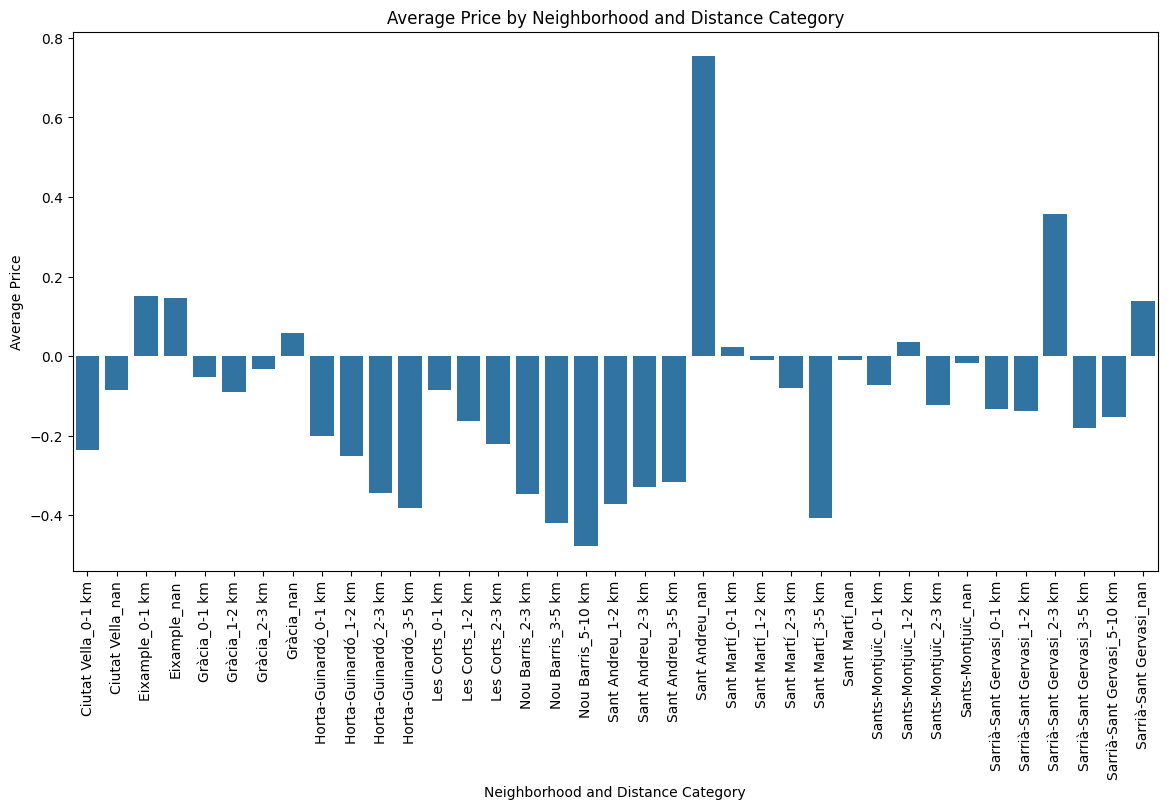

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create an interaction term
# Ensure both columns are of type string before concatenation
df_bcn['neighborhood_distance_interaction'] = df_bcn['neighbourhood_group_cleansed'].astype(str) + '_' + df_bcn['distance_category'].astype(str)


# Grouped analysis
grouped_data = df_bcn.groupby(['neighborhood_distance_interaction']).agg({
    'price': ['mean', 'median', 'count'],
    'review_scores_rating': ['mean', 'std']
}).reset_index()

# Visualization
plt.figure(figsize=(14, 7))
sns.barplot(x='neighborhood_distance_interaction', y=('price', 'mean'), data=grouped_data)
plt.title('Average Price by Neighborhood and Distance Category')
plt.xlabel('Neighborhood and Distance Category')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()

## Price Categorization Using Percentiles

In [45]:
# Calculate percentiles
low_cost_threshold = df_bcn['price'].quantile(0.33)  # Change quantile values as per requirement
economic_threshold = df_bcn['price'].quantile(0.66)

# Categorize prices into 'Luxury', 'Economic', and 'Low-Cost'
df_bcn['price_category'] = pd.cut(df_bcn['price'], bins=[df_bcn['price'].min(), low_cost_threshold, economic_threshold, df_bcn['price'].max()],
                              labels=['Low-Cost', 'Economic', 'Luxury'], include_lowest=True)

# Display the distribution of price categories
print(df_bcn['price_category'].value_counts())

# Optionally, view some rows to confirm the categorization
print(df_bcn[['price', 'price_category']].head())


price_category
Luxury      6349
Economic    6276
Low-Cost    6232
Name: count, dtype: int64
      price price_category
0 -0.067063       Economic
1 -0.413151       Low-Cost
2  0.207772         Luxury
3  0.146697         Luxury
4  0.180628         Luxury


#### - Percentiles: The quantile function is used to determine the thresholds for each category. In this example, 33% of listings fall into 'Low-Cost', the next 33% into 'Economic', and the remaining 34% into 'Luxury'.
#### - Categorization: pd.cut is used to segment the price into categories based on these thresholds. The bins parameter specifies the edges of the bins, and labels assigns names to these bins.
#### - Visualization: The code prints the count of listings in each category to help you verify the distribution.

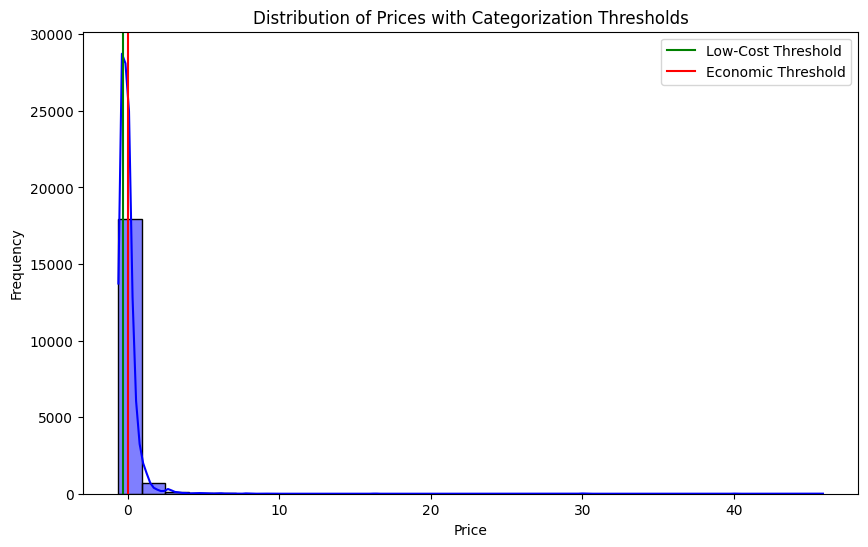

In [46]:
# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(df_bcn['price'], bins=30, kde=True, color='blue')
plt.axvline(x=low_cost_threshold, color='green', label='Low-Cost Threshold')
plt.axvline(x=economic_threshold, color='red', label='Economic Threshold')
plt.title('Distribution of Prices with Categorization Thresholds')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## The visual is not very representative - due to a large number of observations fall into a small price range, and a few outliers extend the scale of the plot. 


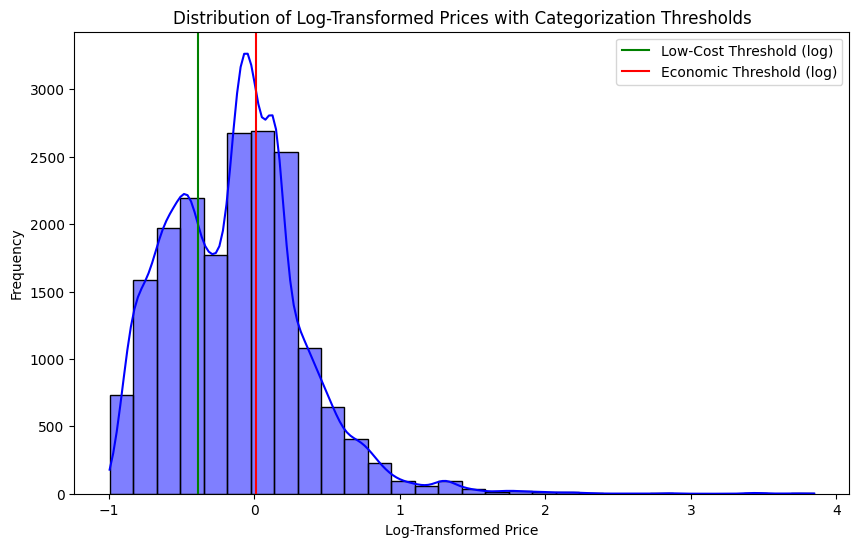

In [47]:

# Assuming 'df_bcn' is your DataFrame and 'price' is the column you are analyzing
df_bcn['log_price'] = np.log1p(df_bcn['price'])  # Apply log transformation to price

# Plotting the histogram with log prices
plt.figure(figsize=(10, 6))
sns.histplot(df_bcn['log_price'], bins=30, kde=True, color='blue')

# Calculate new thresholds on log-transformed prices
log_low_cost_threshold = np.log1p(df_bcn['price']).quantile(0.33)
log_economic_threshold = np.log1p(df_bcn['price']).quantile(0.66)

# Adding vertical lines for new thresholds
plt.axvline(x=log_low_cost_threshold, color='green', label='Low-Cost Threshold (log)')
plt.axvline(x=log_economic_threshold, color='red', label='Economic Threshold (log)')

plt.title('Distribution of Log-Transformed Prices with Categorization Thresholds')
plt.xlabel('Log-Transformed Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Observations:

#### 1. Center of Data Density:

If most listings are concentrated just below the economic threshold, this suggests that the majority of properties are priced at the upper end of the 'Economic' category.
This positioning implies that many properties are close to crossing into the 'Luxury' category, indicating a market where mid-range offerings dominate but with a substantial fraction nearing premium pricing.
Market Positioning:

#### 2. Competitive Pricing: 

The concentration near the economic threshold may suggest that setting prices slightly above this range could position listings as 'affordable luxury', potentially attracting customers looking for slightly higher-end accommodations without moving fully into the luxury price segment.

Marketing Focus: Promotional efforts might focus on the value provided by listings in the upper economic range, highlighting features or amenities that justify nearing the luxury category.
Strategic Insights:

#### 3. Inventory Assessment: 

Evaluate whether there is room to increase amenities or make other improvements that could justify moving these near-luxury listings fully into the luxury category to capture higher per-night rates.

#### 4. Customer Insights: 

Surveys or data analysis could help understand what features or factors would convince customers in the economic range to opt for slightly more expensive listings, potentially informing service improvements or new offerings.

#### 5. Pricing Strategy Adjustments:

Given that many listings are close to the economic threshold, consider experimenting with slight price adjustments to see if there is increased revenue potential without significantly impacting occupancy rates.
Further Statistical Analysis:

#### 6. Elasticity of Demand: 

Analyzing how changes in prices affect booking rates (price elasticity of demand) for listings near this threshold could provide actionable insights into how price-sensitive your customers are in this segment.
Segment-Specific Promotion: Tailoring promotions and discounts to capture the dense cluster of listings just below the economic threshold could optimize both occupancy and nightly rates.

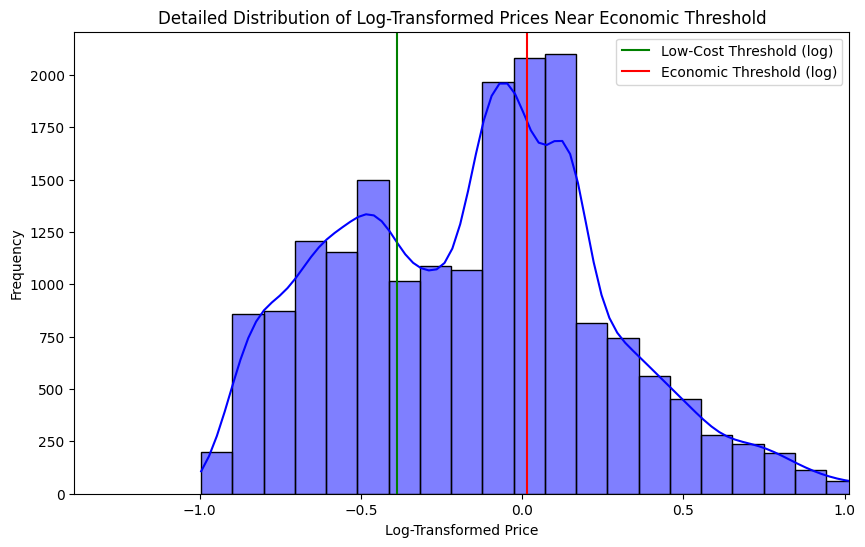

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Focusing on the dense region near the economic threshold
plt.figure(figsize=(10, 6))
sns.histplot(df_bcn['log_price'], bins=50, kde=True, color='blue')
plt.axvline(x=log_low_cost_threshold, color='green', label='Low-Cost Threshold (log)')
plt.axvline(x=log_economic_threshold, color='red', label='Economic Threshold (log)')

# Zooming into the region of interest
plt.xlim([log_low_cost_threshold - 1, log_economic_threshold + 1])  # Adjust the limits as needed to focus on the region of interest

plt.title('Detailed Distribution of Log-Transformed Prices Near Economic Threshold')
plt.xlabel('Log-Transformed Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [49]:
# file_path2 = 'datasets/Final_cleaned_dataset/mad_final_cleaned_data_csv.csv'
# df_mad = pd.read_csv(file_path2, delimiter = ';')

# # Display the first few rows and the column names
# df_mad.head(), df_mad.columns